# Chapter 19: A Step-By-Step Tutorial On How To Build A Machine Learning Model

by Sandra Vieira, Rafael Garcia-Dias, Walter Hugo Lopez Pinaya 


---
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MLMH-Lab/How-To-Build-A-Machine-Learning-Model/blob/master/chapter_19_script.ipynb)

Here we present a step-by-step tutorial on the implementation of a standard supervised machine learning pipeline using Python programming language. We use a toy dataset with neuroimaging-based data (i.e. grey matter volume and thickness from different brain regions extracted with FreeSurfer) to classify patients with schizophrenia and healthy controls using a Support Vector Machine. This tutorial is aimed at the machine learning novice and assumes minimal programming experience.

The sample code follows the same workflow described in Chapter 2 of the book.





Let's start!



## Importing libraries

In [0]:
# SNIPPET 1
# Store and organize output files
from pathlib import Path

# Manipulate data
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical tests
import scipy.stats as stats

# Machine learning
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Ignore WARNING
import warnings

warnings.filterwarnings('ignore')

Some steps in our analysis will be subjected to randomness.  We set the seed value to a fixed number to guarantee that we get the same results every time we run the code. 

In [0]:
# SNIPPET 2
random_seed = 1
np.random.seed(random_seed)

## Organize the workspace

 First, we create the structure of folders where we can store all the results.

In [0]:
# SNIPPET 3
results_dir = Path('./results')
results_dir.mkdir(exist_ok=True)

experiment_name = 'linear_SVM_example'
experiment_dir = results_dir / experiment_name
experiment_dir.mkdir(exist_ok=True)

## Problem formulation

 In this tutorial, our machine learning problem is: 

> *Classify patients with schizophrenia and healthy controls using structural MRI data.*

From this formulation we can derive the main elements of our machine learning problem:

*   **Features**: Structural MRI data
*   **Task**: Binary classification
*   **Target**: Patients with schizophrenia and healthy controls



---



## Data Preparation

The aim of this step is to perform a series of statistical analyses to get the data ready for the machine learning model.

### Loading the data

In [0]:
# SNIPPET 4
# dataset_file = Path('./Chapter_19_data.csv')
dataste_url = 'https://github.com/MLMH-Lab/How-To-Build-A-Machine-Learning-Model/raw/master/Chapter_19_data.csv'
dataset_df = pd.read_csv(dataste_url, index_col='ID')

In [0]:
# SNIPPET 5
patient_str = 'sz'
healthy_str = 'hc'
male_str = 'M'
female_str = 'F'

In [6]:
# SNIPPET 6
dataset_df[0:6]

,Diagnosis,Gender,Age,Left Lateral Ventricle,Left Inf Lat Vent,Left Cerebellum White Matter,Left Cerebellum Cortex,Left Thalamus Proper,Left Caudate,Left Putamen,Left Pallidum,rd Ventricle,th Ventricle,Brain Stem,Left Hippocampus,Left Amygdala,CSF,Left Accumbens area,Left VentralDC,Right Lateral Ventricle,Right Inf Lat Vent,Right Cerebellum White Matter,Right Cerebellum Cortex,Right Thalamus Proper,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens area,Right VentralDC,CC Posterior,CC Mid Posterior,CC Central,CC Mid Anterior,CC Anterior,lh bankssts volume,lh caudalanteriorcingulate volume,lh caudalmiddlefrontal volume,lh cuneus volume,...,lh superiortemporal thickness,lh supramarginal thickness,lh frontalpole thickness,lh temporalpole thickness,lh transversetemporal thickness,lh insula thickness,rh bankssts thickness,rh caudalanteriorcingulate thickness,rh caudalmiddlefrontal thickness,rh cuneus thickness,rh entorhinal thickness,rh fusiform thickness,rh inferiorparietal thickness,rh inferiortemporal thickness,rh isthmuscingulate thickness,rh lateraloccipital thickness,rh lateralorbitofrontal thickness,rh lingual thickness,rh medialorbitofrontal thickness,rh middletemporal thickness,rh parahippocampal thickness,rh paracentral thickness,rh parsopercularis thickness,rh parsorbitalis thickness,rh parstriangularis thickness,rh pericalcarine thickness,rh postcentral thickness,rh posteriorcingulate thickness,rh precentral thickness,rh precuneus thickness,rh rostralanteriorcingulate thickness,rh rostralmiddlefrontal thickness,rh superiorfrontal thickness,rh superiorparietal thickness,rh superiortemporal thickness,rh supramarginal thickness,rh frontalpole thickness,rh temporalpole thickness,rh transversetemporal thickness,rh insula thickness
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c001,hc,M,22.0,4226.907844,414.407845,12242.90784,43410.50784,7020.107844,4133.407844,6467.707844,2048.207844,825.507845,1751.707844,18918.50784,3423.907844,917.007845,907.207845,691.607845,3500.107844,3517.007844,568.407845,13079.90784,44261.50784,6855.307844,4248.407844,6746.707844,1941.307844,3427.807844,1297.107844,618.107845,3837.307844,812.507845,429.107845,520.707845,407.907845,745.407845,1242.007844,911.007845,4082.007844,3236.007844,...,2.464844,2.409844,2.712844,1.940844,2.206844,2.895844,2.320844,2.229844,2.517844,1.879844,3.004844,2.726844,2.516844,2.604844,2.430844,2.323844,2.507844,2.072844,2.571844,2.731844,2.866844,2.279844,2.505844,2.828844,2.433844,1.523844,1.999844,2.487844,2.484844,2.312844,2.440844,2.522844,2.656844,2.123844,2.638844,2.420844,2.489844,2.235844,2.300844,2.645844
c002,hc,F,24.0,4954.912699,414.812699,16519.51270,38808.31270,7013.312699,3882.912699,5781.012699,1735.912699,457.512699,1123.312699,20193.91270,3582.712699,1578.712699,708.212699,593.812699,3802.312699,3420.612699,258.512699,16028.81270,44035.41270,6654.512699,3477.012699,5121.112699,1619.612699,3322.212699,1402.112699,529.412699,3842.312699,1034.512699,446.112699,495.012699,772.512699,815.412699,2596.012699,1493.012699,7759.012699,3268.012699,...,2.635699,2.560699,3.013699,2.452699,2.308699,2.859699,2.573699,2.141699,2.687699,1.904699,3.248699,2.408699,2.485699,2.558699,2.233699,2.181699,2.595699,2.095699,2.375699,2.659699,2.301699,2.456699,2.426699,2.823699,2.513699,1.967699,2.002699,2.297699,2.625699,2.273699,2.507699,2.470699,2.645699,2.132699,2.848699,2.425699,2.883699,2.622699,2.322699,2.673699
c003,hc,F,22.0,4470.611989,370.111989,10193.51199,38637.51199,5802.911989,2941.711989,5802.511989,1467.411989,835.011989,1050.011989,17577.51199,3338.211989,1318.311989,754.911989,702.611989,3444.511989,4097.511989,157.611989,14706.71199,42082.01199,5799.311989,3225.411989,4863.311989,1402.311989,3645.711989,1347.911989,588.011989,3924.011989,1067.911989,450.011989,492.411989,476.011989,888.611989,2556.011989,1633.011989,6815.011989,3291.011989,...,2.410989,2.451989,2.125989,2.332989,

In [7]:
# SNIPPET 7
dataset_df.columns.tolist()

['Diagnosis',
 'Gender',
 'Age',
 'Left Lateral Ventricle',
 'Left Inf Lat Vent',
 'Left Cerebellum White Matter',
 'Left Cerebellum Cortex',
 'Left Thalamus Proper',
 'Left Caudate',
 'Left Putamen',
 'Left Pallidum',
 'rd Ventricle',
 'th Ventricle',
 'Brain Stem',
 'Left Hippocampus',
 'Left Amygdala',
 'CSF',
 'Left Accumbens area',
 'Left VentralDC',
 'Right Lateral Ventricle',
 'Right Inf Lat Vent',
 'Right Cerebellum White Matter',
 'Right Cerebellum Cortex',
 'Right Thalamus Proper',
 'Right Caudate',
 'Right Putamen',
 'Right Pallidum',
 'Right Hippocampus',
 'Right Amygdala',
 'Right Accumbens area',
 'Right VentralDC',
 'CC Posterior',
 'CC Mid Posterior',
 'CC Central',
 'CC Mid Anterior',
 'CC Anterior',
 'lh bankssts volume',
 'lh caudalanteriorcingulate volume',
 'lh caudalmiddlefrontal volume',
 'lh cuneus volume',
 'lh entorhinal volume',
 'lh fusiform volume',
 'lh inferiorparietal volume',
 'lh inferiortemporal volume',
 'lh isthmuscingulate volume',
 'lh lateralocci

In [8]:
# SNIPPET 8
print('Number of features = %d' % dataset_df.shape[1])
print('Number of participants = %d' % dataset_df.shape[0])

Number of features = 172
Number of participants = 740


In order to recreate some of the most common issues when building a machine learning pipeline, our data preparation stage will check the dataset for the following:




*   Missing data
*   Data imbalance with respect to the labels
*   Confounding variables


### Missing data

In [9]:
# SNIPPET 9
null_lin_bool = dataset_df.isnull().any(axis=1)
null_cols = dataset_df.columns[dataset_df.isnull().any(axis=0)]

n_null = dataset_df.isnull().sum().sum()
print('Number of missing data = %d' % n_null)
subj_null = dataset_df[null_lin_bool].index
print('IDs: %s' % (', ').join(subj_null.tolist()))

Number of missing data = 43
IDs: c006, p149, p150, p156, p157, p175, p195, p196, p197, p210, p211, p212, p227, p228, p229, p264, p265, p266, p267, p268, p269, p270, p271, p281, p282, p283, p289, p302, p303, p307, p311, p312, p319, p321, p356, p357, p358, p359, p360, p361, p362, p363, p364


In [10]:
# SNIPPET 9a
pd.DataFrame(dataset_df[null_cols].isnull().sum(), columns=['N missing'])

,N missing
Age,43


In [11]:
# SNIPPET 10
dataset_df = dataset_df.dropna()
print('Number of participants = %d' % dataset_df.shape[0])

Number of participants = 697


### Class imbalance

Next, let's check the number of total participants in each class. 

In [12]:
# SNIPPET 11
dataset_df['Diagnosis'].value_counts()

hc    367
sz    330
Name: Diagnosis, dtype: int64

There does not seem to be a large imbalance between classes.

### Confounding variables

There are many potential confounding variables one might want to inspect. Here, we will investigate two obvious ones: gender and age. 


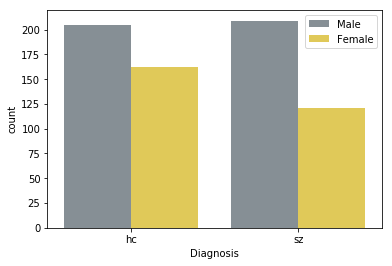

In [13]:
# SNIPPET 12
sns.countplot(x='Diagnosis', hue='Gender', data=dataset_df, palette=['#839098', '#f7d842'])
plt.legend(['Male', 'Female'])
plt.show()

In addition to visualizing the data, it is good practice to always perform an appropriate statistical test, even if there is no noticeable bias in the visual inspection.

In [14]:
# SNIPPET 13
# Create the contingency table
contingency_table = pd.crosstab(dataset_df['Gender'], dataset_df['Diagnosis'])
print(contingency_table)

# Perform the homogeneity test
chi2, p_gender, _, _ = stats.chi2_contingency(contingency_table, correction=False)
print('Gender')
print('Chi-square test: chi2 stats = %.3f p-value = %.3f' % (chi2, p_gender))


Diagnosis   hc   sz
Gender             
F          162  121
M          205  209
Gender
Chi-square test: chi2 stats = 4.026 p-value = 0.045


In [15]:
# SNIPPET 14
print('Removing participant to balance gender...')
while p_gender < 0.05:
    # Randomly select a woman from healthy controls
    hc_women = dataset_df[(dataset_df['Diagnosis'] == healthy_str) & (dataset_df['Gender'] == female_str)]
    indexes_to_remove = hc_women.sample(n=1, random_state=1).index

    # Remove her from dataset
    print('Droping %s' % str(indexes_to_remove.values[0]))
    dataset_df = dataset_df.drop(indexes_to_remove)
    contingency_table = pd.crosstab(dataset_df['Gender'], dataset_df['Diagnosis'])
    chi2, p_gender, _, _ = stats.chi2_contingency(contingency_table, correction=False)
    print('new p-value = %.3f' % p_gender)

print('Gender')
print('Chi-square test: chi2 stats = %.3f p-value = %.3f' % (chi2, p_gender))

# Check new sample size
contingency_table = pd.crosstab(dataset_df['Gender'], dataset_df['Diagnosis'])
print(contingency_table)

Removing participant to balance gender...
Droping c082
new p-value = 0.049
Droping c083
new p-value = 0.054
Gender
Chi-square test: chi2 stats = 3.698 p-value = 0.054
Diagnosis   hc   sz
Gender             
F          160  121
M          205  209


Next, let's check for any imbalance with respect to age. 

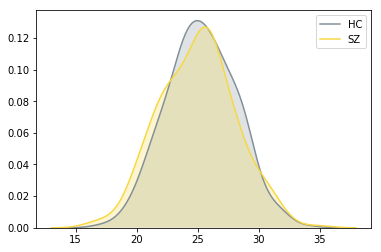

HC: Normality test: p-value = 0.005
SZ: Normality test: p-value = 0.018
Age
HC: Mean(SD) = 25.31(2.84)
SZ: Mean(SD) = 24.98(3.12)


In [16]:
# SNIPPET 15
age_hc = dataset_df[dataset_df['Diagnosis'] == healthy_str]['Age']
age_sz = dataset_df[dataset_df['Diagnosis'] == patient_str]['Age']

# Plot normal curve
sns.kdeplot(age_hc,
            color='#839098',
            label='HC',
            shade=True)
sns.kdeplot(age_sz,
            color='#f7d842',
            label='SZ',
            shade=True)
plt.show()

# Shapiro test for normality
_, p_age_hc_normality = stats.shapiro(age_hc)
_, p_age_sz_normality = stats.shapiro(age_sz)

print('HC: Normality test: p-value = %.3f' % p_age_hc_normality)
print('SZ: Normality test: p-value = %.3f' % p_age_sz_normality)

# Descriptives
print('Age')
print('HC: Mean(SD) = %.2f(%.2f)' % (age_hc.mean(), age_hc.std()))
print('SZ: Mean(SD) = %.2f(%.2f)' % (age_sz.mean(), age_sz.std()))

In [17]:
# SNIPPET 16
t_stats, p_age = stats.ttest_ind(age_sz, age_hc)
print('Age')
print("Student's t-test: t stats = %.3f, p-value = %.3f" % (t_stats, p_age))

Age
Student's t-test: t stats = -1.464, p-value = 0.144


### Feature set and target

Our next step is to retrieve the target and features from the dataset.

In [0]:
# SNIPPET 17
# Target
targets_df = dataset_df['Diagnosis']

# Features
features_names = dataset_df.columns[3:]
features_df = dataset_df[features_names]

In [19]:
# SNIPPET 17a
features_df

,Left Lateral Ventricle,Left Inf Lat Vent,Left Cerebellum White Matter,Left Cerebellum Cortex,Left Thalamus Proper,Left Caudate,Left Putamen,Left Pallidum,rd Ventricle,th Ventricle,Brain Stem,Left Hippocampus,Left Amygdala,CSF,Left Accumbens area,Left VentralDC,Right Lateral Ventricle,Right Inf Lat Vent,Right Cerebellum White Matter,Right Cerebellum Cortex,Right Thalamus Proper,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens area,Right VentralDC,CC Posterior,CC Mid Posterior,CC Central,CC Mid Anterior,CC Anterior,lh bankssts volume,lh caudalanteriorcingulate volume,lh caudalmiddlefrontal volume,lh cuneus volume,lh entorhinal volume,lh fusiform volume,lh inferiorparietal volume,...,lh superiortemporal thickness,lh supramarginal thickness,lh frontalpole thickness,lh temporalpole thickness,lh transversetemporal thickness,lh insula thickness,rh bankssts thickness,rh caudalanteriorcingulate thickness,rh caudalmiddlefrontal thickness,rh cuneus thickness,rh entorhinal thickness,rh fusiform thickness,rh inferiorparietal thickness,rh inferiortemporal thickness,rh isthmuscingulate thickness,rh lateraloccipital thickness,rh lateralorbitofrontal thickness,rh lingual thickness,rh medialorbitofrontal thickness,rh middletemporal thickness,rh parahippocampal thickness,rh paracentral thickness,rh parsopercularis thickness,rh parsorbitalis thickness,rh parstriangularis thickness,rh pericalcarine thickness,rh postcentral thickness,rh posteriorcingulate thickness,rh precentral thickness,rh precuneus thickness,rh rostralanteriorcingulate thickness,rh rostralmiddlefrontal thickness,rh superiorfrontal thickness,rh superiorparietal thickness,rh superiortemporal thickness,rh supramarginal thickness,rh frontalpole thickness,rh temporalpole thickness,rh transversetemporal thickness,rh insula thickness
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c001,4226.907844,414.407845,12242.907840,43410.50784,7020.107844,4133.407844,6467.707844,2048.207844,825.507845,1751.707844,18918.50784,3423.907844,917.007845,907.207845,691.607845,3500.107844,3517.007844,568.407845,13079.907840,44261.50784,6855.307844,4248.407844,6746.707844,1941.307844,3427.807844,1297.107844,618.107845,3837.307844,812.507845,429.107845,520.707845,407.907845,745.407845,1242.007844,911.007845,4082.007844,3236.007844,1992.007844,8908.007844,12371.007840,...,2.464844,2.409844,2.712844,1.940844,2.206844,2.895844,2.320844,2.229844,2.517844,1.879844,3.004844,2.726844,2.516844,2.604844,2.430844,2.323844,2.507844,2.072844,2.571844,2.731844,2.866844,2.279844,2.505844,2.828844,2.433844,1.523844,1.999844,2.487844,2.484844,2.312844,2.440844,2.522844,2.656844,2.123844,2.638844,2.420844,2.489844,2.235844,2.300844,2.645844
c002,4954.912699,414.812699,16519.512700,38808.31270,7013.312699,3882.912699,5781.012699,1735.912699,457.512699,1123.312699,20193.91270,3582.712699,1578.712699,708.212699,593.812699,3802.312699,3420.612699,258.512699,16028.812700,44035.41270,6654.512699,3477.012699,5121.112699,1619.612699,3322.212699,1402.112699,529.412699,3842.312699,1034.512699,446.112699,495.012699,772.512699,815.412699,2596.012699,1493.012699,7759.012699,3268.012699,1850.012699,9055.012699,12232.012700,...,2.635699,2.560699,3.013699,2.452699,2.308699,2.859699,2.573699,2.141699,2.687699,1.904699,3.248699,2.408699,2.485699,2.558699,2.233699,2.181699,2.595699,2.095699,2.375699,2.659699,2.301699,2.456699,2.426699,2.823699,2.513699,1.967699,2.002699,2.297699,2.625699,2.273699,2.507699,2.470699,2.645699,2.132699,2.848699,2.425699,2.883699,2.622699,2.322699,2.673699
c003,4470.611989,370.111989,10193.511990,38637.51199,5802.911989,2941.711989,5802.511989,1467.411989,835.011989,1050.011989,17577.51199,3338.211989,1318.311989,754.911989,702.611989,3444.511989,4097.511989,157.611989,14706.711990,42082.01199,5799.311989,3225.411989,4863.311989,1402.311989,3645.711989,1347.911989,588.011989,3924.011989,1067.911989,450.011989,492.411989,476.011989,888

In [0]:
# SNIPPET 18
features_df.to_csv(experiment_dir / 'prepared_features.csv')
targets_df.to_csv(experiment_dir / 'prepared_targets.csv')

In [0]:
# SNIPPET 19
targets_df = targets_df.map({healthy_str: 0, patient_str: 1})
targets = targets_df.values.astype('int')

features = features_df.values.astype('float32')

## Feature engineering


### Feature extraction
In our example, we want to use neuroanatomical data to classify SZ and HC. This requires the extraction of brain morphometric information from the raw MRI images.


### Feature scaling/normalization 
In brain disorders research, we often deal with datasets that contain features that vary in units and range. However, to model the data correctly and effectively, most machine learning algorithms require the data to be on the same scale. Since normalization involves statistics (e.g. mean and variance) of the set used to train the model, in this point we split the data into training and test sets following the scheme a cross-validation.

In [0]:
# SNIPPET 20
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)

In [0]:
# SNIPPET 21
predictions_df = pd.DataFrame(targets_df)
predictions_df['predictions'] = np.nan

bac_cv = np.zeros((n_folds, 1))
sens_cv = np.zeros((n_folds, 1))
spec_cv = np.zeros((n_folds, 1))
coef_cv = np.zeros((n_folds, len(features_names)))

models_dir = experiment_dir / 'models'
models_dir.mkdir(exist_ok=True)

In [24]:
# --------------------------------------------------------------------------
# SNIPPET 22
for i_fold, (train_idx, test_idx) in enumerate(skf.split(features, targets)):
    features_train, features_test = features[train_idx], features[test_idx]
    targets_train, targets_test = targets[train_idx], targets[test_idx]

    print('CV iteration: %d' % (i_fold + 1))
    print('Training set size: %d' % len(targets_train))
    print('Test set size: %d' % len(targets_test))

    # --------------------------------------------------------------------------
    # SNIPPET 23
    # Feature scaling/normalization
    scaler = StandardScaler()

    scaler.fit(features_train)

    features_train_norm = scaler.transform(features_train)
    features_test_norm = scaler.transform(features_test)

    # --------------------------------------------------------------------------
    # SNIPPET 24
    # Here, we will use the linear kernel, as this will make it easier to extract the coefficients
    #  of the SVM model (feature importance) later on.
    clf = LinearSVC(loss='hinge')

    # --------------------------------------------------------------------------
    # SNIPPET 25
    # SVM relies on a hyperparameter C that regulates how much we want to avoid misclassifying each
    #  training example.

    # Hyper-parameter search space
    param_grid = {'C': [2 ** -6, 2 ** -5, 2 ** -4, 2 ** -3, 2 ** -2, 2 ** -1, 2 ** 0, 2 ** 1]}

    # Grid search
    internal_cv = StratifiedKFold(n_splits=10)
    grid_cv = GridSearchCV(estimator=clf,
                           param_grid=param_grid,
                           cv=internal_cv,
                           scoring='balanced_accuracy',
                           verbose=1)

    # --------------------------------------------------------------------------
    # SNIPPET 26
    # Model training
    grid_result = grid_cv.fit(features_train_norm, targets_train)

    # --------------------------------------------------------------------------
    # SNIPPET 27
    print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print('%f (%f) with: %r' % (mean, stdev, param))

    # --------------------------------------------------------------------------
    # SNIPPET 28
    best_clf = grid_cv.best_estimator_

    joblib.dump(best_clf, models_dir / ('classifier_%d.joblib' % i_fold))
    joblib.dump(scaler, models_dir / ('scaler_%d.joblib' % i_fold))

    # --------------------------------------------------------------------------
    # SNIPPET 29
    # Model’s coefficients
    # In addition to model performance, we are also interested in knowing which features
    #  are driving the model's predictions.
    coef_cv[i_fold, :] = np.abs(best_clf.coef_)

    # --------------------------------------------------------------------------
    # SNIPPET 30
    # Model evaluation
    # Finally, we use the final trained model best_clf to make predictions in the test set.
    target_test_predicted = best_clf.predict(features_test_norm)

    for row, value in zip(test_idx, target_test_predicted):
        predictions_df.iloc[row, predictions_df.columns.get_loc('predictions')] = value

    # --------------------------------------------------------------------------
    # SNIPPET 31
    print('Confusion matrix')
    cm = confusion_matrix(targets_test, target_test_predicted)
    print(cm)

    tn, fp, fn, tp = cm.ravel()

    bac_test = balanced_accuracy_score(targets_test, target_test_predicted)
    sens_test = tp / (tp + fn)
    spec_test = tn / (tn + fp)

    print('Balanced accuracy: %.3f ' % bac_test)
    print('Sensitivity: %.3f ' % sens_test)
    print('Specificity: %.3f ' % spec_test)

    bac_cv[i_fold, :] = bac_test
    sens_cv[i_fold, :] = sens_test
    spec_cv[i_fold, :] = spec_test
    print('--------------------------------------------------------------------------')

CV iteration: 1
Training set size: 625
Test set size: 70
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best: 0.679176 using {'C': 0.125}
0.668418 (0.076022) with: {'C': 0.015625}
0.666650 (0.087195) with: {'C': 0.03125}
0.678872 (0.085597) with: {'C': 0.0625}
0.679176 (0.090932) with: {'C': 0.125}
0.677330 (0.077958) with: {'C': 0.25}
0.670166 (0.081358) with: {'C': 0.5}
0.658900 (0.083517) with: {'C': 1}
0.640877 (0.080590) with: {'C': 2}
Confusion matrix
[[27 10]
 [11 22]]
Balanced accuracy: 0.698 
Sensitivity: 0.667 
Specificity: 0.730 
--------------------------------------------------------------------------
CV iteration: 2
Training set size: 625
Test set size: 70
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best: 0.694949 using {'C': 0.03125}
0.687267 (0.093274) with: {'C': 0.015625}
0.694949 (0.101588) with: {'C': 0.03125}
0.688924 (0.096595) with: {'C': 0.0625}
0.680056 (0.073606) with: {'C': 0.125}
0.675733 (0.058243) with: {'C': 0.25}
0.653819 (0.069998) with: {'C': 0.5}
0.644799 (0.070451) with: {'C': 1}
0.643474 (0.070870) with: {'C': 2}
Confusion matrix
[[29  8]
 [12 21]]
Balanced accuracy: 0.710 
Sensitivity: 0.636 
Specificity: 0.784 
--------------------------------------------------------------------------
CV iteration: 3
Training set size: 625
Test set size: 70
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best: 0.682687 using {'C': 0.125}
0.659930 (0.100158) with: {'C': 0.015625}
0.666779 (0.076560) with: {'C': 0.03125}
0.679388 (0.057382) with: {'C': 0.0625}
0.682687 (0.076657) with: {'C': 0.125}
0.653693 (0.083404) with: {'C': 0.25}
0.660605 (0.070639) with: {'C': 0.5}
0.652343 (0.058557) with: {'C': 1}
0.670182 (0.059810) with: {'C': 2}
Confusion matrix
[[29  8]
 [ 7 26]]
Balanced accuracy: 0.786 
Sensitivity: 0.788 
Specificity: 0.784 
--------------------------------------------------------------------------
CV iteration: 4
Training set size: 625
Test set size: 70
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best: 0.696782 using {'C': 0.015625}
0.696782 (0.098881) with: {'C': 0.015625}
0.689010 (0.089328) with: {'C': 0.03125}
0.691613 (0.092005) with: {'C': 0.0625}
0.688574 (0.085687) with: {'C': 0.125}
0.672631 (0.101341) with: {'C': 0.25}
0.682516 (0.109559) with: {'C': 0.5}
0.665407 (0.113689) with: {'C': 1}
0.656265 (0.100309) with: {'C': 2}
Confusion matrix
[[29  8]
 [ 8 25]]
Balanced accuracy: 0.771 
Sensitivity: 0.758 
Specificity: 0.784 
--------------------------------------------------------------------------
CV iteration: 5
Training set size: 625
Test set size: 70
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best: 0.714187 using {'C': 0.0625}
0.670444 (0.079381) with: {'C': 0.015625}
0.697139 (0.079858) with: {'C': 0.03125}
0.714187 (0.069730) with: {'C': 0.0625}
0.703273 (0.073274) with: {'C': 0.125}
0.691783 (0.066561) with: {'C': 0.25}
0.676126 (0.077086) with: {'C': 0.5}
0.683702 (0.079006) with: {'C': 1}
0.678387 (0.089198) with: {'C': 2}
Confusion matrix
[[31  6]
 [12 21]]
Balanced accuracy: 0.737 
Sensitivity: 0.636 
Specificity: 0.838 
--------------------------------------------------------------------------
CV iteration: 6
Training set size: 626
Test set size: 69
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best: 0.693222 using {'C': 0.25}
0.653271 (0.073043) with: {'C': 0.015625}
0.666018 (0.089550) with: {'C': 0.03125}
0.677777 (0.097648) with: {'C': 0.0625}
0.678908 (0.108031) with: {'C': 0.125}
0.693222 (0.077959) with: {'C': 0.25}
0.666884 (0.090709) with: {'C': 0.5}
0.669217 (0.095389) with: {'C': 1}
0.650836 (0.085774) with: {'C': 2}
Confusion matrix
[[26 10]
 [ 9 24]]
Balanced accuracy: 0.725 
Sensitivity: 0.727 
Specificity: 0.722 
--------------------------------------------------------------------------
CV iteration: 7
Training set size: 626
Test set size: 69
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best: 0.683363 using {'C': 0.0625}
0.667076 (0.089267) with: {'C': 0.015625}
0.676330 (0.099209) with: {'C': 0.03125}
0.683363 (0.092676) with: {'C': 0.0625}
0.678124 (0.086521) with: {'C': 0.125}
0.670735 (0.085402) with: {'C': 0.25}
0.675055 (0.080006) with: {'C': 0.5}
0.675575 (0.079750) with: {'C': 1}
0.670069 (0.073789) with: {'C': 2}
Confusion matrix
[[24 12]
 [ 6 27]]
Balanced accuracy: 0.742 
Sensitivity: 0.818 
Specificity: 0.667 
--------------------------------------------------------------------------
CV iteration: 8
Training set size: 626
Test set size: 69
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best: 0.682176 using {'C': 0.0625}
0.674345 (0.077028) with: {'C': 0.015625}
0.678100 (0.089218) with: {'C': 0.03125}
0.682176 (0.076869) with: {'C': 0.0625}
0.673080 (0.086784) with: {'C': 0.125}
0.656848 (0.080758) with: {'C': 0.25}
0.661757 (0.078730) with: {'C': 0.5}
0.656970 (0.081262) with: {'C': 1}
0.670580 (0.080510) with: {'C': 2}
Confusion matrix
[[28  8]
 [ 9 24]]
Balanced accuracy: 0.753 
Sensitivity: 0.727 
Specificity: 0.778 
--------------------------------------------------------------------------
CV iteration: 9
Training set size: 626
Test set size: 69
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best: 0.681371 using {'C': 0.03125}
0.652724 (0.100736) with: {'C': 0.015625}
0.681371 (0.096755) with: {'C': 0.03125}
0.674752 (0.085348) with: {'C': 0.0625}
0.671340 (0.099615) with: {'C': 0.125}
0.659714 (0.089081) with: {'C': 0.25}
0.662081 (0.097241) with: {'C': 0.5}
0.652684 (0.098323) with: {'C': 1}
0.649922 (0.099185) with: {'C': 2}
Confusion matrix
[[31  5]
 [ 7 26]]
Balanced accuracy: 0.824 
Sensitivity: 0.788 
Specificity: 0.861 
--------------------------------------------------------------------------
CV iteration: 10
Training set size: 626
Test set size: 69
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best: 0.689529 using {'C': 0.0625}
0.672018 (0.078200) with: {'C': 0.015625}
0.666056 (0.074977) with: {'C': 0.03125}
0.689529 (0.075954) with: {'C': 0.0625}
0.688752 (0.077506) with: {'C': 0.125}
0.674303 (0.084499) with: {'C': 0.25}
0.676190 (0.093909) with: {'C': 0.5}
0.672173 (0.095262) with: {'C': 1}
0.657715 (0.110870) with: {'C': 2}
Confusion matrix
[[

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    6.9s finished


In [25]:
# SNIPPET 32
print('CV results')
print('Bac: Mean(SD) = %.3f(%.3f)' % (bac_cv.mean(), bac_cv.std()))
print('Sens: Mean(SD) = %.3f(%.3f)' % (sens_cv.mean(), sens_cv.std()))
print('Spec: Mean(SD) = %.3f(%.3f)' % (spec_cv.mean(), spec_cv.std()))

CV results
Bac: Mean(SD) = 0.753(0.036)
Sens: Mean(SD) = 0.724(0.061)
Spec: Mean(SD) = 0.781(0.059)


In [0]:
# SNIPPET 33
# Saving feature importance
mean_coef = np.mean(coef_cv, axis=0).reshape(1, -1)

coef_df = pd.DataFrame(data=mean_coef, columns=features_names.values)
coef_df.to_csv(experiment_dir / 'feature_importance.csv', index=False)

# Saving predictions
predictions_df.to_csv(experiment_dir / 'predictions.csv', index=True)

# Saving metrics
metrics = np.concatenate((bac_cv, sens_cv, spec_cv), axis=1)
metrics_df = pd.DataFrame(data=metrics, columns=['bac', 'sens', 'spec'])
metrics_df.index.name = 'CV iteration'
metrics_df.to_csv(experiment_dir / 'metrics.csv', index=True)

## Post-hoc analysis

Once we have our final model, we can run several additional analyses. Here, we will run the following:

*   Test balanced accuracy, sensitivity and specificity for statistical significance via permutation testing
*   Identify the features that provided the greatest contribution to the task 

First, we organize the folder to store the results of this analysis.


In [0]:
# SNIPPET 34
permutation_dir = experiment_dir / 'permutation'
permutation_dir.mkdir(exist_ok=True)

Next, we store our model’s final bac, sens and spec. This will come in handy later on

In [0]:
# SNIPPET 35
bac_from_model = bac_cv.mean()
sens_from_model = sens_cv.mean()
spec_from_model = spec_cv.mean()

In [0]:
# SNIPPET 36
# n_permutations = 1000
n_permutations = 10
bac_perm = np.zeros((n_permutations, 1))
sens_perm = np.zeros((n_permutations, 1))
spec_perm = np.zeros((n_permutations, 1))
coef_perm = np.zeros((n_permutations, len(features_names)))

We then apply the exact same pipeline to the same dataset with the shuffled labels. Note how the code below follows the same instructions as in snippets 21 through 31. 

In [36]:
# SNIPPET 37
for i_perm in range(n_permutations):
    print('Permutation: %d' % (i_perm + 1))

    np.random.seed(i_perm)
    targets_permuted = np.random.permutation(targets)

    # --------------------------------------------------------------------------
    # SNIPPET 38

    n_folds = 10
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)

    bac_cv = np.zeros((n_folds, 1))
    sens_cv = np.zeros((n_folds, 1))
    spec_cv = np.zeros((n_folds, 1))
    coef_cv = np.zeros((n_folds, len(features_names)))

    for i_fold, (train_idx, test_idx) in enumerate(skf.split(features, targets_permuted)):
        features_train, features_test = features[train_idx], features[test_idx]
        targets_train, targets_test = targets_permuted[train_idx], targets_permuted[test_idx]

        scaler = StandardScaler()
        features_train_norm = scaler.fit_transform(features_train)
        features_test_norm = scaler.transform(features_test)

        clf = LinearSVC(loss='hinge')

        param_grid = {'C': [2 ** -6, 2 ** -5, 2 ** -4, 2 ** -3, 2 ** -2, 2 ** -1, 2 ** 0, 2 ** 1]}

        internal_cv = StratifiedKFold(n_splits=10)
        grid_cv = GridSearchCV(estimator=clf,
                               param_grid=param_grid,
                               cv=internal_cv,
                               scoring='balanced_accuracy',
                               verbose=0)

        grid_result = grid_cv.fit(features_train_norm, targets_train)

        best_clf = grid_cv.best_estimator_

        coef_cv[i_fold, :] = np.abs(best_clf.coef_)

        target_test_predicted = best_clf.predict(features_test_norm)

        cm = confusion_matrix(targets_test, target_test_predicted)

        tn, fp, fn, tp = cm.ravel()

        bac_test = balanced_accuracy_score(targets_test, target_test_predicted)
        sens_test = tp / (tp + fn)
        spec_test = tn / (tn + fp)

        bac_cv[i_fold, :] = bac_test
        sens_cv[i_fold, :] = sens_test
        spec_cv[i_fold, :] = spec_test

    # --------------------------------------------------------------------------
    # SNIPPET 39
    np.save(permutation_dir / ('perm_test_bac_%03d.npy' % i_perm), bac_cv.mean())
    np.save(permutation_dir / ('perm_test_sens_%03d.npy' % i_perm), sens_cv.mean())
    np.save(permutation_dir / ('perm_test_spec_%03d.npy' % i_perm), spec_cv.mean())
    np.save(permutation_dir / ('perm_coef_%03d.npy' % i_perm), coef_cv.mean(axis=0))

    bac_perm[i_perm, :] = bac_cv.mean()
    sens_perm[i_perm, :] = sens_cv.mean()
    spec_perm[i_perm, :] = spec_cv.mean()
    coef_perm[i_perm, :] = coef_cv.mean(axis=0)

Permutation: 1
Permutation: 2
Permutation: 3
Permutation: 4
Permutation: 5
Permutation: 6
Permutation: 7
Permutation: 8
Permutation: 9
Permutation: 10


In [32]:
# SNIPPET 40
# Get p_values from metrics
bac_p_value = (np.sum(bac_perm >= bac_from_model) + 1) / (n_permutations + 1)
sens_p_value = (np.sum(sens_perm >= sens_from_model) + 1) / (n_permutations + 1)
spec_p_value = (np.sum(spec_perm >= spec_from_model) + 1) / (n_permutations + 1)

print('BAC: p-value = %.3f' % bac_p_value)
print('SENS: p-value = %.3f' % sens_p_value)
print('SPEC: p-value = %.3f' % spec_p_value)

BAC: p-value = 0.091
SENS: p-value = 0.091
SPEC: p-value = 0.091


Let’s also estimate the statistical significance of the model’s coefficients. This will allow us to check which features made a statistically significant contribution to the task.

In [0]:
# SNIPPET 41
# Get p_values from coef
coef_p_values = np.zeros((1, len(features_names)))
for i_feature in range(len(features_names)):
    coef_value_from_perm = coef_perm[:, i_feature]
    coef_value_from_model = mean_coef[0, i_feature]

    n_perm_better_model = np.sum(coef_value_from_perm >= coef_value_from_model)

    coef_p_values[0, i_feature] = (n_perm_better_model + 1) / (n_permutations + 1)


In [34]:
# SNIPPET 42
coef_df = pd.DataFrame(index=['coefficients', 'p value'],
                       data=np.concatenate((mean_coef, coef_p_values)),
                       columns=features_names)

coef_df.sort_values('coefficients', axis=1, ascending=False).T

,coefficients,p value
lh middletemporal thickness,0.850079,0.090909
Right Amygdala,0.662941,0.090909
rd Ventricle,0.661329,0.090909
lh parahippocampal thickness,0.614925,0.090909
lh middletemporal volume,0.452947,0.090909
rh parahippocampal thickness,0.386146,0.090909
Left Hippocampus,0.370431,0.090909
Left Amygdala,0.329124,0.090909
lh medialorbitofrontal thickness,0.303272,0.090909
lh rostralanteriorcingulate thickness,0.300831,0.090909


In [0]:
# SNIPPET 43
# Saving
perm_metrics_df = pd.DataFrame(data={'metric': ['bac', 'sens', 'spec'],
                                     'value': [bac_from_model,
                                               sens_from_model,
                                               spec_from_model],
                                     'p_value': [bac_p_value,
                                                 sens_p_value,
                                                 spec_p_value]})

perm_metrics_df.to_csv(experiment_dir / 'metrics_permutation_pvalue.csv', index=False)

coef_df.to_csv(experiment_dir / 'coef_permutation_pvalue.csv', index=True)
